In [89]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import warnings
warnings.filterwarnings('ignore')

In [113]:
## data merge
confirmed_global='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recover_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
confirmed = pd.read_csv(confirmed_global)
death = pd.read_csv(death_global)
recover = pd.read_csv(recover_global)

dates = confirmed.columns[4:]
confirmed_df = confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                              value_vars=dates, var_name='Date', value_name='Confirmed').fillna('').drop(['Lat', 'Long'], axis=1)
deaths_df = death.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                       value_vars=dates, var_name='Date', value_name='Deaths').fillna('').drop(['Lat', 'Long'], axis=1)
recovered_df = recover.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                       value_vars=dates, var_name='Date', value_name='Recovered').fillna('').drop(['Lat', 'Long'], axis=1)

In [114]:
recovered_df = recovered_df[recovered_df['Country/Region']!='Canada']

In [115]:
full_table = confirmed_df.merge(right=deaths_df, 
                                how='left',
                                on=['Province/State', 'Country/Region', 'Date'])
full_table = full_table.merge(right=recovered_df, 
                              how='left',
                              on=['Province/State', 'Country/Region', 'Date'])

In [116]:
full_table['Date'] = [d.split()[0] for d in full_table['Date']]
full_table['Recovered'] = full_table['Recovered'].fillna(0)

ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

full_table = full_table[~(ship_rows)]

In [160]:
full_table['Date'] = pd.to_datetime(full_table['Date'])

In [161]:
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

In [162]:
#get global data
global_table = full_table.groupby(['Date'], as_index = False).sum().reset_index().drop('index', axis = 1)
#get country data
country_table = full_table.groupby(['Date', 'Country/Region'], as_index = False).sum()
def get_country(country):
    df = country_table[country_table['Country/Region'] == country].reset_index().drop('index', axis = 1)
    # return only when there is first confirmed case
    m = (df.Confirmed != 0).idxmax(1)
    return df.iloc[m:,].reset_index().drop('index', axis = 1)

In [179]:
def get_days(df, feature, days_in_future = 10):
    m = (df[feature] != 0).idxmax(1)
    df = df.iloc[m:,].reset_index().drop('index', axis = 1)
    days = df.index.values.reshape(-1,1)
    future_forcast = np.array([i for i in range(len(days)+days_in_future)]).reshape(-1, 1)
    adjusted_dates = future_forcast[:-days_in_future]
    start = df.Date[0].strftime('%m/%d/%Y')
    start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
    future_forcast_dates = []
    
    for i in range(len(future_forcast)):
        future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
    return days, future_forcast_dates, adjusted_dates
def get_cases(df, feature):
    return df[feature].values.reshape(-1, 1)

In [191]:
#global confirm
days, future_forcast_dates, adujusted_dates = get_days(global_table, feature = 'Confirmed')
global_confirm = get_cases(global_table, 'Confirmed')

#split train and test
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days[50:], global_confirm[50:], test_size=0.05, shuffle=False) 

MAE: 1899788.2367772667
MSE: 3651537089460.593


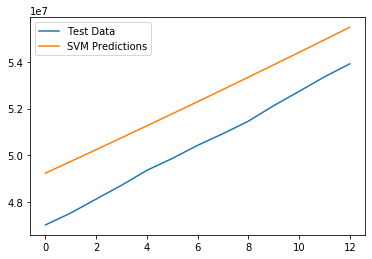

In [192]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [193]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,11/15/2020,56044460.0
1,11/16/2020,56594366.0
2,11/17/2020,57147963.0
3,11/18/2020,57705263.0
4,11/19/2020,58266278.0
5,11/20/2020,58831021.0
6,11/21/2020,59399504.0
7,11/22/2020,59971739.0
8,11/23/2020,60547739.0
9,11/24/2020,61127515.0


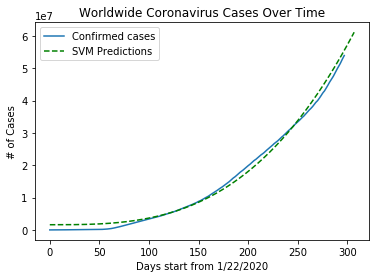

In [194]:
def plot_predictions(x, y, pred, legend_name, color, xlabel):
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time')
    plt.xlabel(xlabel)
    plt.ylabel('# of Cases')
    plt.legend(legend_name)
    plt.xticks()
    plt.yticks()
    plt.show()
plot_predictions(adjusted_dates, global_confirm, svm_pred, ['Confirmed cases','SVM Predictions'], 'green', 'Days start from 1/22/2020')

In [205]:
#global deaths
days, future_forcast_dates, adujusted_dates = get_days(global_table, feature = 'Deaths')
global_death = get_cases(global_table, 'Deaths')

In [206]:
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days[50:], global_death[50:], test_size=0.05, shuffle=False)

MAE: 207498.63465484805
MSE: 43267963856.42175


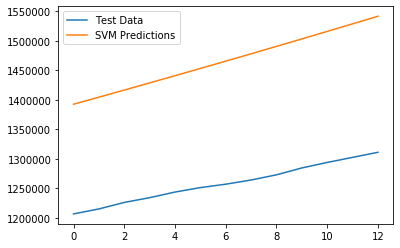

In [207]:
# svm_death = svm_search.best_estimator_
svm_death = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_death.fit(X_train_death, y_train_death)
svm_pred = svm_death.predict(future_forcast)
# check against testing data
svm_test_pred = svm_death.predict(X_test_death)
plt.plot(y_test_death)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_death))
print('MSE:',mean_squared_error(svm_test_pred, y_test_death))

In [208]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Death Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Death Cases Worldwide
0,11/15/2020,1554748.0
1,11/16/2020,1567821.0
2,11/17/2020,1580981.0
3,11/18/2020,1594230.0
4,11/19/2020,1607566.0
5,11/20/2020,1620992.0
6,11/21/2020,1634506.0
7,11/22/2020,1648109.0
8,11/23/2020,1661802.0
9,11/24/2020,1675585.0


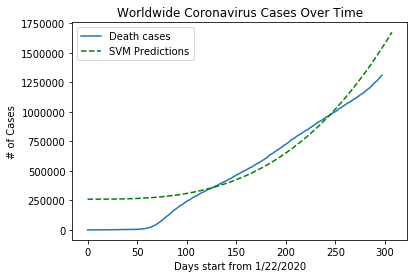

In [198]:
plot_predictions(adjusted_dates, global_death, svm_pred, ['Death cases','SVM Predictions'], 'green', 'Days start from 1/22/2020')

In [209]:
#global recover
global_recover = get_cases(global_table, 'Recovered')
days, future_forcast_dates, adujusted_dates = get_days(global_table, feature = 'Recovered')
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(days[50:], global_recover[50:], test_size=0.05, shuffle=False)

MAE: 3273792.6268773754
MSE: 10850386946369.854


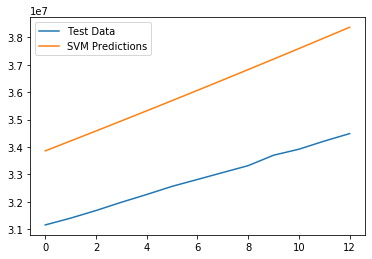

In [210]:
#svm_death = svm_search.best_estimator_
svm_re = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_re.fit(X_train_re, y_train_re)
svm_pred = svm_re.predict(future_forcast)
# check against testing data
svm_test_pred = svm_re.predict(X_test_re)
plt.plot(y_test_re)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_re))
print('MSE:',mean_squared_error(svm_test_pred, y_test_re))

In [211]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Recovered Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Recovered Cases Worldwide
0,11/15/2020,38765004.0
1,11/16/2020,39160745.0
2,11/17/2020,39559142.0
3,11/18/2020,39960204.0
4,11/19/2020,40363940.0
5,11/20/2020,40770358.0
6,11/21/2020,41179467.0
7,11/22/2020,41591277.0
8,11/23/2020,42005797.0
9,11/24/2020,42423034.0


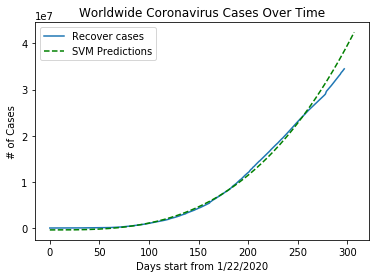

In [204]:
plot_predictions(adjusted_dates, global_recover, svm_pred, ['Recover cases','SVM Predictions'], 'green', 'Days start from 1/22/2020')

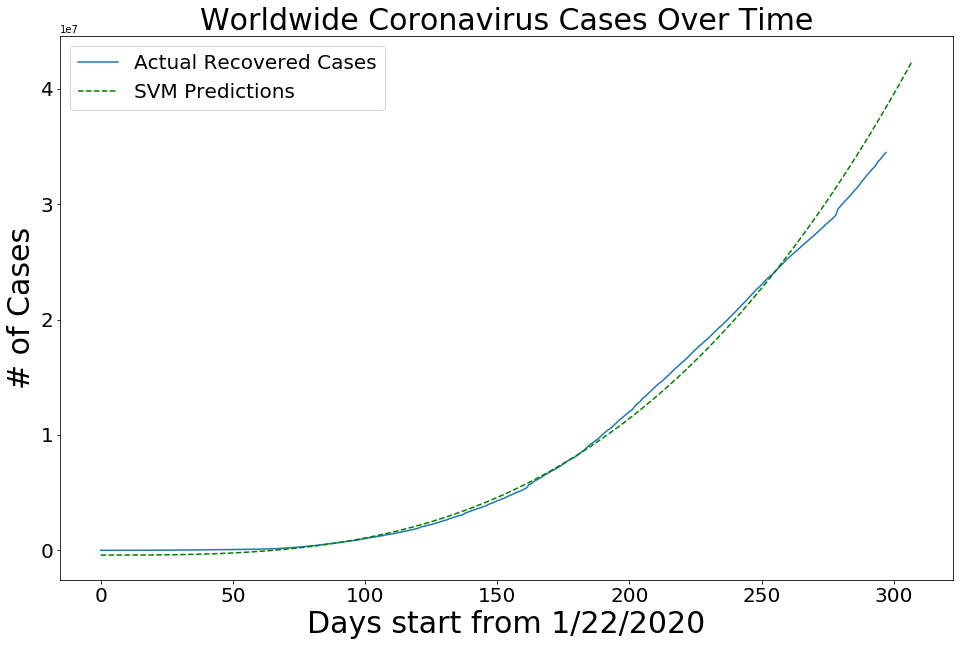

In [217]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, global_recover)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='green')
plt.title('Worldwide Coronavirus Cases Over Time', size=30)
plt.xlabel('Days start from 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Actual Recovered Cases', 'SVM Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()